# Use emcee to sample Lya posterior as a function of mean flux

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import lya_theory
import likelihood

## Setup Lya likelihood function

In [2]:
# read P1D measurement
#data=data_PD2013.P1D_PD2013(blind_data=True)
data=data_PD2013.P1D_PD2013(blind_data=True,zmin=2.1,zmax=4.5)
zs=data.z

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_512_15062019/'
#basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
p1d_label=None
skewers_label=None
undersample_z=2
paramList=None
#paramList=["Delta2_p","mF","sigT_Mpc","gamma","kF_Mpc"]
emu_type='NGP'
if emu_type=='polyGP':
    emu=gp_emulator.PolyfitGPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                               verbose=True,paramList=paramList,train=True)
elif emu_type=='kGP':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                               verbose=True,paramList=paramList,train=True)
elif emu_type=='linear':
    # specify parameters to emulate
    emulate_slope=False
    emulate_growth=False
    emulate_running=False
    emulate_pressure=True
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                                       emulate_slope=emulate_slope,emulate_running=emulate_running,
                                       emulate_pressure=emulate_pressure,emulate_growth=emulate_growth,verbose=False)
elif emu_type=='NGP':
    emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                                       verbose=False)
else:
    raise ValueError('wrong emulator type '+emu_type)

In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=True)

Note: redshifts have been re-sorted (earliest first)


In [5]:
like=likelihood.Likelihood(data=data,theory=theory,verbose=True)

got parameters
g_star = 0.9677508579459803
f_star = 0.98136955784
Delta2_star = 0.360175905286
n_star = -2.29933566726
alpha_star = -0.216527037121
ln_tau_0 = -0.794580172414
ln_tau_1 = 3.18
ln_T0_0 = 9.21034037198
ln_T0_1 = 0.0
ln_gamma_0 = 0.336472236621
ln_gamma_1 = 0.0
ln_kF_0 = -1.70374859191
ln_kF_1 = 0
likelihood setup with 1 free parameters
1 free parameters


In [6]:
for p in like.free_params:
    print(p.name,p.value)

ln_tau_0 -0.794580172414


In [7]:
# test likelihood function
values=[0.5]
like.log_prob(values=values)

0 2.2 model {'Delta2_p': 0.55651130145771688, 'n_p': -2.2994794185069685, 'alpha_p': -0.21637589659957746, 'f_p': 0.96522452450210083, 'mF': 0.83448643777956488, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.13069600926052841, 'kF_Mpc': 12.672154332566837}
1 2.4 model {'Delta2_p': 0.49488568402750766, 'n_p': -2.2994795015019927, 'alpha_p': -0.21637671767578953, 'f_p': 0.97065366319224333, 'mF': 0.80299190268821985, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12744692725288601, 'kF_Mpc': 12.995213267980114}
2 2.6 model {'Delta2_p': 0.44280074273630693, 'n_p': -2.2994793009304835, 'alpha_p': -0.21637578130992885, 'f_p': 0.97499691285123324, 'mF': 0.76862970398372188, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12436389094838281, 'kF_Mpc': 13.317370398835509}
3 2.8 model {'Delta2_p': 0.39841920050635804, 'n_p': -2.2994793725990892, 'alpha_p': -0.21637637290771081, 'f_p': 0.97850450521187982, 'mF': 0.73160691033963021, 'gamma': 1.3999999999999999, 'sigT_Mpc': 0.12144623367196278, 'kF_Mpc': 13.6

-1678.2164706426222

In [8]:
#cProfile.run("like.log_prob(values=values,linP_Mpc_params=linP_Mpc_params)",sort='cumtime')

### Setup function to be called in MCMC

In [9]:
def log_prob(values,like,verbose=False):
    test_log_prob=like.log_prob(values=values)
    if np.isnan(test_log_prob):
        if verbose:
            print('parameter values outside hull',values)
        return -np.inf
    return test_log_prob

In [10]:
like.go_silent()

In [11]:
np.exp(-np.exp(-2.0))

0.87342301849311665

In [12]:
xs=np.linspace(0.0,1.0,100)
xmin=like.free_params[0].min_value
xmax=like.free_params[0].max_value
print(xmin,'< ln_tau_0 <',xmax)
print(np.exp(xmin),'< tau_0 <',np.exp(xmax))
print(np.exp(-np.exp(xmax)),'< <F> <',np.exp(-np.exp(xmin)))
mf=np.exp(-np.exp(xmin+xs*(xmax-xmin)))
lnps=[log_prob([x],like) for x in xs]

-1.5 < ln_tau_0 < -0.5
0.223130160148 < tau_0 < 0.606530659713
0.545239211893 < <F> < 0.800010713004


Text(0, 0.5, '$\\chi^2$')

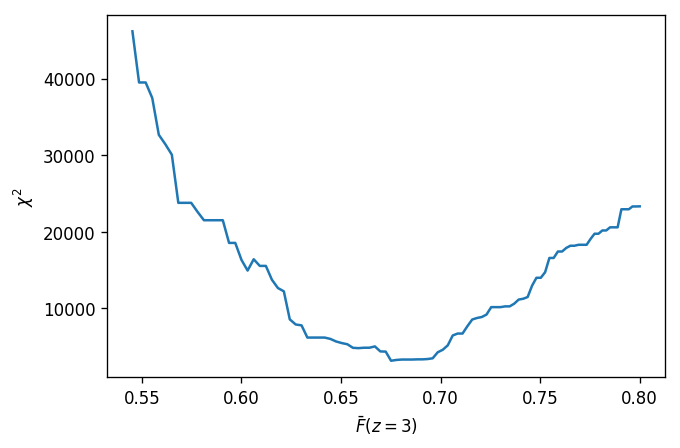

In [13]:
plt.plot(mf,-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

### Setup MCMC

In [14]:
# for now we'll have only one dimension (mean flux)
ndim=1
# setup initial walkers
nwalkers = 10
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [15]:
p0.flatten()

array([ 0.05072003,  0.28986949,  0.30568858,  0.29514302,  0.24672257,
        0.07066448,  0.89842671,  0.59820598,  0.05413956,  0.91418497])

In [16]:
# test function
log_prob(p0[0],like)

-11472.738314861273

In [17]:
# setup sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[like])

In [18]:
# burn-in phase
pos, prob, state = sampler.run_mcmc(p0, 50)
print('finished burn-in at',pos.flatten(),prob)

finished burn-in at [ 0.55348278  0.56018747  0.56047218  0.55324979  0.56100462  0.56031144
  0.56376541  0.563511    0.53396531  0.62011321] [-1638.93304199 -1513.69292366 -1513.69292366 -1638.93304199 -1551.21083808
 -1513.69292366 -1551.21083808 -1551.21083808 -1666.05535285 -2379.90704609]


In [19]:
# reset and run actual chains
sampler.reset()
nsteps=200
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 20 == 0:
        print(i,result[0].flatten())

0 [ 0.54877959  0.56018747  0.56047218  0.55324979  0.56141528  0.56022267
  0.56298602  0.563511    0.54037854  0.62011321]
20 [ 0.5610161   0.56031283  0.56043457  0.56120176  0.56058723  0.56034912
  0.56054735  0.56122802  0.55729465  0.62011321]
40 [ 0.56311145  0.56030009  0.56044206  0.56339458  0.56026987  0.56049485
  0.56059242  0.56344316  0.55603727  0.62011321]
60 [ 0.56147392  0.56041998  0.56016664  0.5604377   0.56061364  0.56061178
  0.56058869  0.56021687  0.54801656  0.62011321]
80 [ 0.56145158  0.5602094   0.56029725  0.5605313   0.56063092  0.56042762
  0.5604109   0.56027786  0.55434631  0.62011321]
100 [ 0.56053465  0.56029445  0.56040758  0.56042196  0.56051273  0.56026524
  0.56050686  0.56015534  0.54764264  0.62011321]
120 [ 0.56045748  0.56028782  0.56029732  0.56050832  0.56055357  0.56039757
  0.56052765  0.56040403  0.54814638  0.62011321]
140 [ 0.56022934  0.56016135  0.56018773  0.56040581  0.56056105  0.56029229
  0.56047601  0.56034817  0.55586174  0.

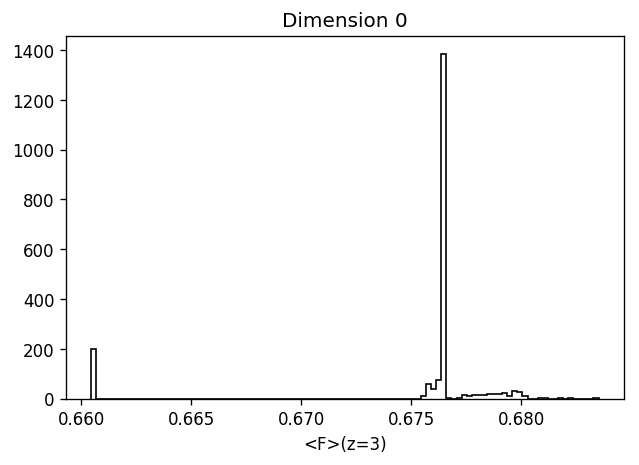

In [20]:
for i in range(ndim):
    plt.figure()
    mf=np.exp(-np.exp(xmin+sampler.flatchain[:,i]*(xmax-xmin)))
    plt.hist(mf, 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [21]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.554


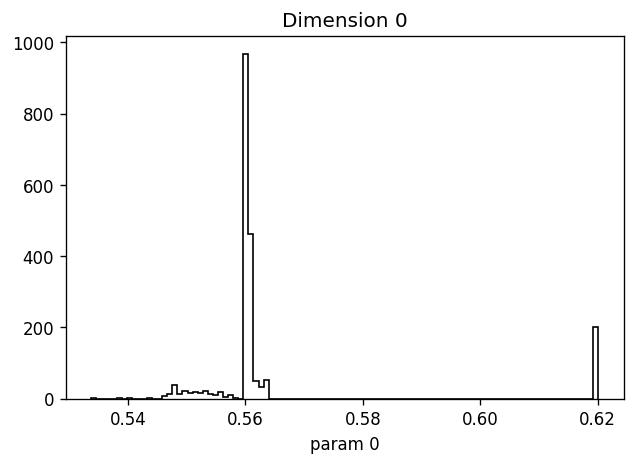

In [22]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))

In [26]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.lnprobability, axis=None), sampler.lnprobability.shape)
best_fit=sampler.chain[ind]

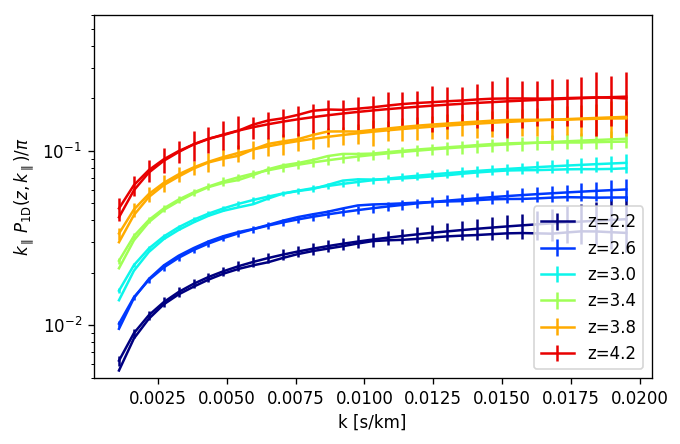

In [27]:
like.plot_p1d(plot_every_iz=2,values=best_fit)